# Reconstruction du noyau
## Régularisation par Laplacien

Ici la régularisation utilisée pour la reconstruction du noyau est le Laplacien 2D.

$$
\text{min} \; E(K) = 
\frac{\alpha}{2} \|\Delta K\|^2 
+ \frac{\mu}{2} \| K  \circledast x_i - x_b\|^2
$$

In [1]:
import numpy as np
import os
from PIL import Image
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
%matplotlib inline
# Local import
from Codes.dataprocess import DataLoader, Blurr, Add_noise
from Codes.estimator import Estimator_Lap, Estimator
from Codes.posttreat import Display
from Codes.posttreat import Error_Display
from Codes.simplex import Simplex

##### Kernel

(40, 40)

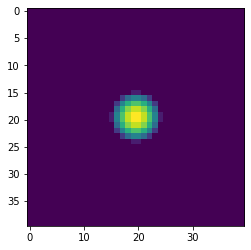

In [2]:
M         = 20
Nx, Ny    = np.meshgrid(np.linspace(-1,1,2*M), np.linspace(-1,1,2*M))
grph      = np.sqrt(Nx*Nx+Ny*Ny)
sigma, mu = 1.0, 0.0
K         = np.exp(-( (grph-mu)**2 / ( 2.0 * sigma**2 ) ) )
K         = Simplex(K)
plt.imshow(K)
K.shape

##### Image

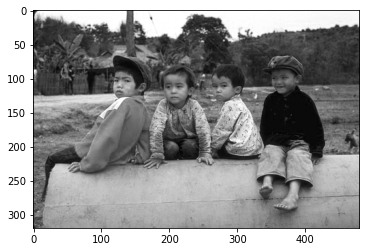

In [3]:
file_name = 'Images'
im_name   = 'image05.jpg'
x_i       = DataLoader(file_name,im_name)
# Reglage de la taille de l'image
x_i       = x_i[:-1,:-1]
x_i       = x_i/np.linalg.norm(x_i)
plt.imshow(x_i,cmap="gray")

In [4]:
m,n = x_i.shape
print(m,n)

320 480


(320, 480)


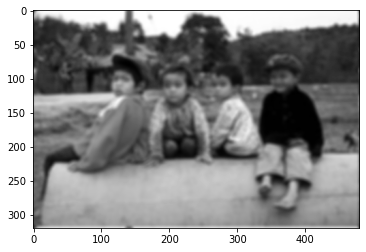

In [5]:
x_b  = Blurr(x_i,K)
x_o1 = Add_noise(x_b)
x_o2 = Add_noise(x_b, noise_level = 0.1)
plt.imshow(x_b,cmap="gray")

#### Laplacian

In [6]:
# Derivation
m,n    = x_i.shape
d      = -np.ones((3,3))
d[1,1] = 8
d_pad  = np.zeros(K.shape)
d_pad[M-1:M+2,M-1:M+2] = d

##### Reconstruction

On souhaite minimiser la fonction,
$$
J(x) =\alpha\| d \circledast x\|^2 +\mu \| x \circledast x_{init} - x_{blurred} \|^2 
\; .
$$
où $d$ est la petite matrice de laplacien
$$
d= \begin{pmatrix}
-1 & -1 & -1 \\
-1 &  8 & -1 \\
-1 & -1 & -1 \\
\end{pmatrix}
\; .
$$

On se place dans le domaine de Fourier pour traiter les convolutions,
$$
J(x) = \alpha\| \hat{d}\hat{x}\| +\mu\| \hat{x}\hat{x}_{init} - \hat{x}_{blurred} \|^2 
\; .
$$

On choisit l'algorithme de descente de gradient 
$$
\begin{cases}
\text{initialisation} \\
\hat{x}_0 , \hat{xi},\hat{xb}, \hat{d}\\
\\
\text{itération}\; \; 0 \leq k \leq N\\
\text{grad} = 2\alpha \hat{d} \hat{d} \hat{x}_k
             + 2\mu \hat{xi}(\hat{xi}\hat{x}_k -\hat{xb}) \\
 \\
 \text{Descente de gradient} \\
\hat{x}_{k+1} = \hat{x}_k - \tau \text{grad} \\
\\
\text{Projection sur le simplex} \\
x_{k+1} = \text{Proj}(x_{k}) \\
\\
\text{Transformée inverse} \\
x_{end} = \text{ifft}(\hat{x}_N)
\end{cases}
$$

Pas constant de descente =  0.00660039889831842


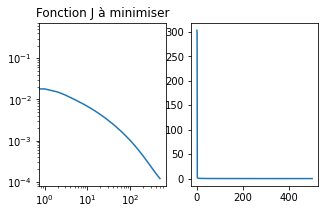

In [7]:
alpha = 0.01
K_alpha, En = Estimator_Lap(M,x_i,x_b,alpha,niter=500,nesterov=True)

In [ ]:
plt.plot(En)

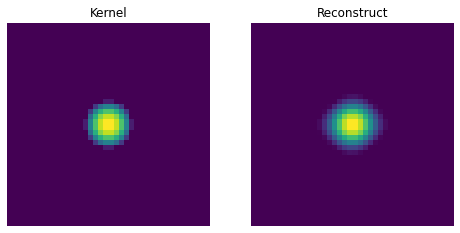

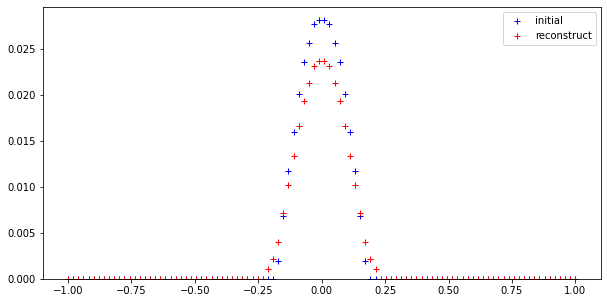

In [8]:
Display(K,K_alpha)

(320, 480)
(320, 480)


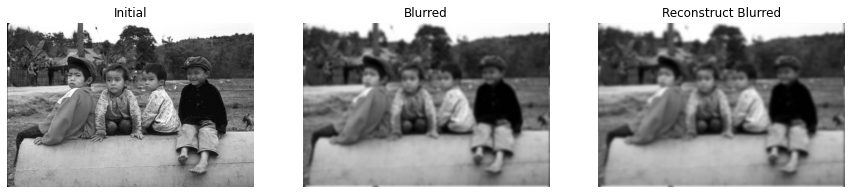

Erreur totale :
0.013153962952739545


In [9]:
Error_Display(x_i,K,K_alpha)

Pas constant de descente =  0.006598891419676676


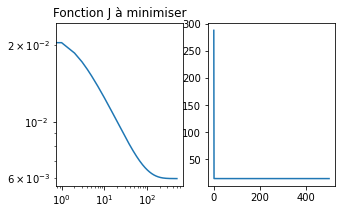

In [10]:
alpha = 1
K_a1,_  = Estimator_Lap(M,x_i,x_o1,alpha,niter = 500)

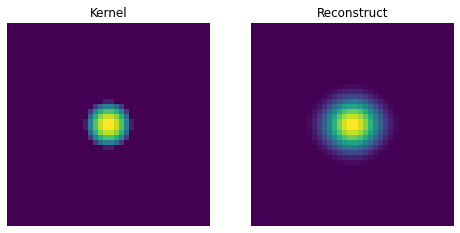

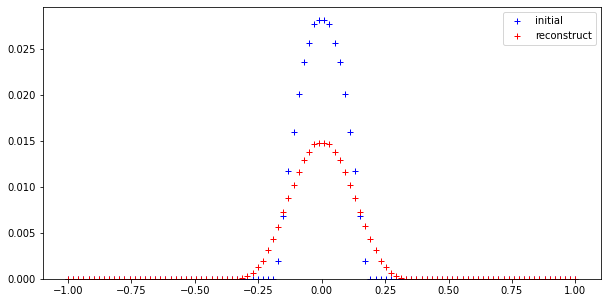

In [11]:
Display(K, K_a1)

Pas constant de descente =  0.006592349288968349


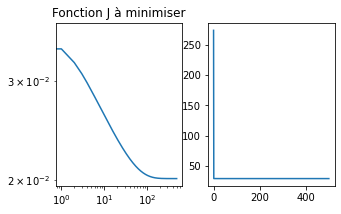

In [12]:
alpha   = 2
K_a2lap,_ = Estimator_Lap(M,x_i,x_o2,alpha,niter = 500)
alpha   = 0.2
K_a2    = Estimator(M,x_i,x_o2,alpha,1,niter = 500)

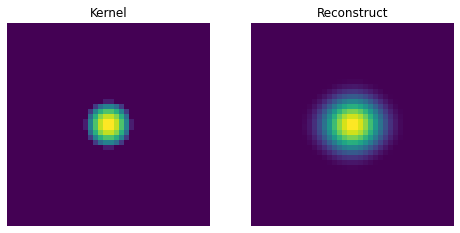

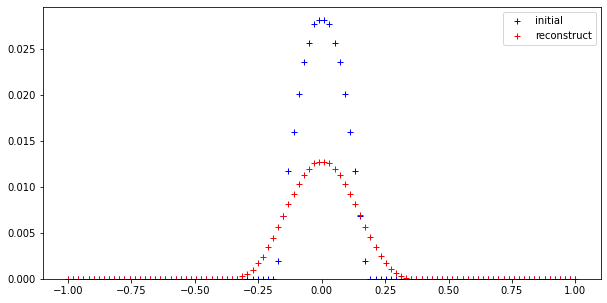

In [13]:
Display(K, K_a2lap)

In [17]:
np.linalg.norm(K-K_a2lap)

0.07751456662108133

In [18]:
np.linalg.norm(K-K_a2)

0.06145147880016963

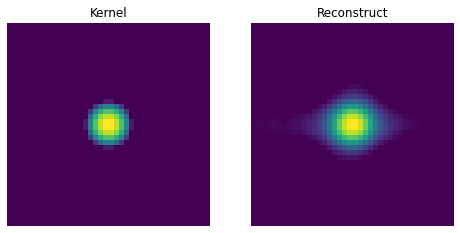

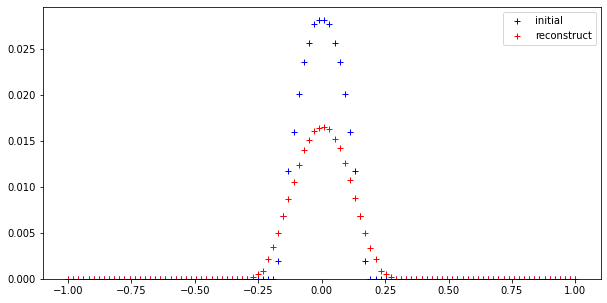

In [14]:
Display(K,K_a2)

## Experience avec autre image

file_name = 'Images'
im_name   = 'image01.png'
x_i2      = DataLoader(file_name,im_name)
x_i2      = x_i2/np.linalg.norm(x_i2)
x_b2      = Blurr(x_i2,K)
x_o12     = Add_noise(x_b2)
x_o22     = Add_noise(x_b2, noise_level = 0.1)
plt.imshow(x_b2,cmap="gray")

In [15]:
alpha = 2
K_a2,_  = Estimator_Lap(M,x_i2,x_o22,alpha,niter = 500)
alpha = 0.2
K_a22 = Estimator(M,x_i2,x_o22,alpha,1,niter = 500)

NameError: name 'x_i2' is not defined

# Calcul annexe

In [ ]:
p,q   = 3, 5
a     = np.linspace(0,1,p*q).reshape(p,q)
b     = np.random.randint(1,10,(p,q))
# Perform fft
fft_a = fft2(a)
fft_b = fft2(b) 
# Compute multiplication and inverse fft
cc    = np.real(ifft2(fft_a*fft_b))
cc    = np.roll(cc, -int(p//2+1),axis=0)
cc    = np.roll(cc, -int(q//2+1),axis=1)

In [ ]:
np.linalg.norm(ifft2(fft_a),ord=2)

In [ ]:
np.linalg.norm(fft_a*fft_b)/np.sqrt(p*q)

In [ ]:
np.linalg.norm(np.real(ifft2(fft_a*fft_b)))

##### Laplacian of an image (test)

In [ ]:
min_x = m//2+1-M-2
max_x = m//2+M-1
min_y = n//2+1-M-2
max_y = n//2+M-1

In [ ]:
def myconvolv(a,b):
    # a and b must be of same size !
    m,n   = a.shape
    # Perform fft
    fft_a = fft2(a)
    fft_b = fft2(b)
    # Compute multiplication and inverse fft
    cc    = np.real(ifft2(fft_a*fft_b))
    cc    = fftshift(cc)
    return cc

In [ ]:
dx = myconvolv(d_pad,K)
plt.imshow(dx,cmap="gray")

In [ ]:
K_pad  = np.zeros(x_i.shape)
K_pad[min_x:max_x,min_y:max_y] = np.exp(-( (grph-0.03)**2 / ( 2.0 * 0.1**2 ) ) )
xtest  = myconvolv(K_pad,x_i)+0.1*np.random.rand(m,n)
plt.imshow(xtest,cmap="gray")

In [ ]:
fft_xi = fft2(x_i)
fft_xb = fft2(x_b)
K2      = np.real(ifft2(fft_xb/fft_xi))
K2      = fftshift(K2)
np.amax(K2[min_x:max_x,min_y:max_y]-K)

##### Test du gradient
On teste que le gradient de la fonction 
$
f(x) = \| d \circledast x\|^2
$
est bien
$$
\nabla f (x) = 2 \bar{d} \circledast d \circledast x
\; ,
$$
où $\bar{d}$ est le symétrisé de $d$.

In [ ]:
def f(x,b):
    p,q  = x.shape
    fftx = fft2(x)
    fftd = fft2(K_pad)
    fftb = fft2(fftshift(b))
    f    = 1/(p*q)*np.linalg.norm(fftd*fftx-fftb)**2
    return f

In [ ]:
def gradf(x,h,b):
    fftx = fft2(x)
    fftd = fft2(K_pad)
    fftb = fft2(fftshift(b))
    # multiplication dans l'espace de Fourier
    fftg = np.conjugate(fftd)*(fftd*fftx-fftb)
    # transformée inverse
    cc = np.real(ifft2(fftg))
    gradf = 2*np.sum(cc*h)
    return gradf

In [ ]:
h = np.random.randn(m,n)
h = 10**-2*h/np.linalg.norm(h)
gradf(x_i,h,xtest)

In [ ]:
f(x_i+h,xtest)-f(x_i,xtest)

In [ ]:
nsamples = 20
hnorm    = np.logspace(-15,0,nsamples)
error    = np.zeros(nsamples)
i        = 0
for t in hnorm:
    h = np.random.randn(m,n)
    h = t*h/np.linalg.norm(h)
    grad1 = f(x_i+h,xtest)-f(x_i,xtest)
    grad2 = gradf(x_i,h,xtest)
    error[i] = abs(grad1-grad2)
    i+=1
plt.loglog(hnorm,error)